In [1]:
###Perform camera calibration, save calibration points
##This needs to be done only once to gather calibration matrix points
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (8,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
print(len(imgpoints))
pickle.dump( {objpoints,imgpoints}, open( "camera_cal.p", "wb" ) )

2


TypeError: unhashable type: 'list'

In [3]:
###Load saved calibration data
import pickle
dist_pickle=pickle.load(open( "wide_dist_pickle.p", "rb" ) )

objpoints=dist_pickle['objpoints']
imgpoints=dist_pickle['imgpoints']

In [4]:
#a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
###EXAMPLE USAGE: undistorted, mtx,dist = cal_undistort(img, objpoints, imgpoints)
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    #img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    undist=dst
    return undist, mtx, dist

In [5]:
### Perspective transform function to warp an image
def warp_transform(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def window_polyfit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curveradius  = find_curvature(ploty, left_fitx)
    right_curveradius = find_curvature(ploty, right_fitx)
    
    #print('left curve:',left_curveradius,'right curve:',right_curveradius)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius

#image = mpimg.imread('./test_images/straight_lines1.jpg')

#plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

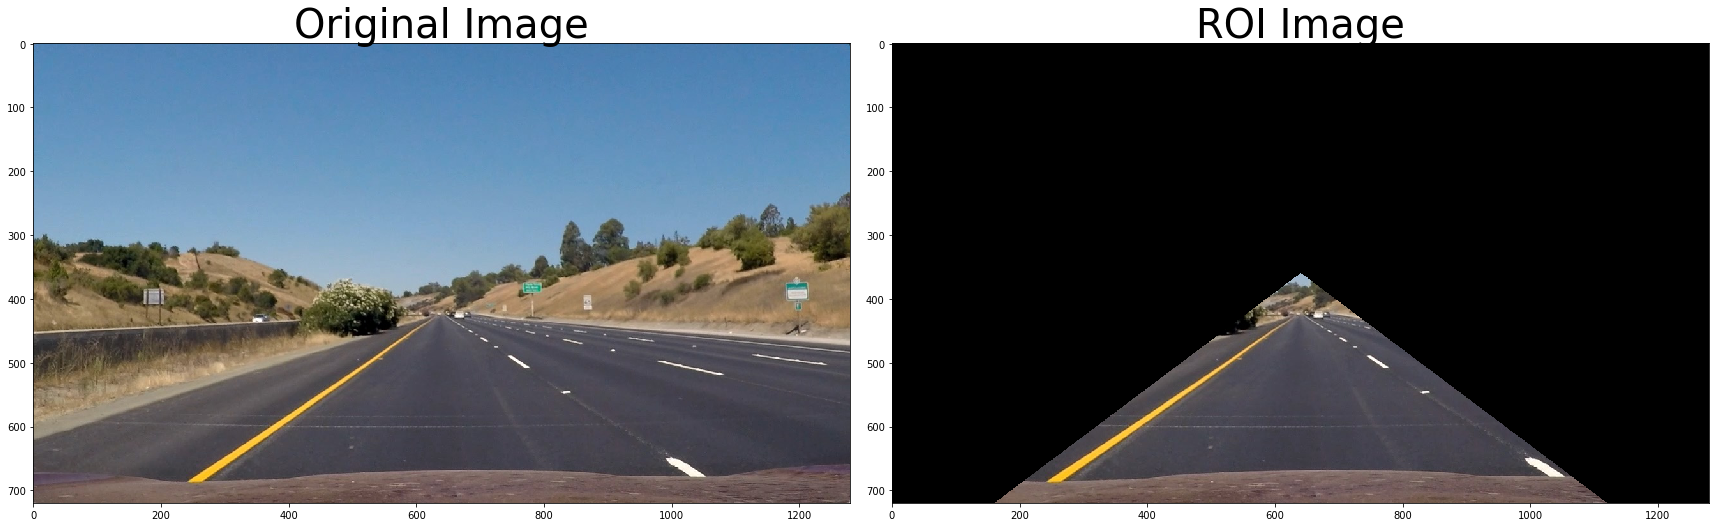

In [7]:
import matplotlib.image as mpimg

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


image = mpimg.imread('./test_images/straight_lines1.jpg')

left_bottom = [1/8*image.shape[1],image.shape[0]]
right_bottom = [7/8*image.shape[1],image.shape[0]]
apex = [image.shape[1]/2,image.shape[0]/2]
apex1 = [image.shape[1]/2,image.shape[0]/2]
      
vertices= np.array([[left_bottom,right_bottom,apex ]],dtype=np.int32)
im=region_of_interest(image,vertices)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(im)
ax2.set_title('ROI Image', fontsize=40)
plt.show()

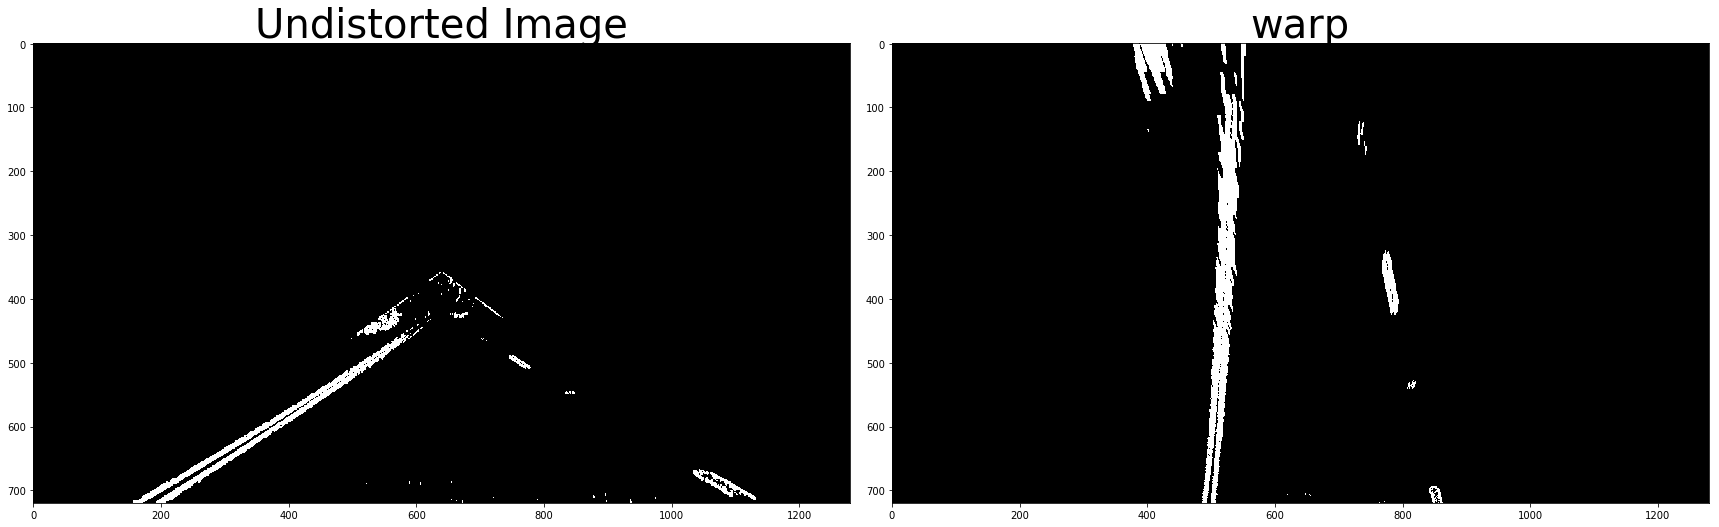

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./test_images/straight_lines1.jpg')
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
left_bottom = [1/8*image.shape[1],image.shape[0]]
right_bottom = [7/8*image.shape[1],image.shape[0]]
apex = [image.shape[1]/2,image.shape[0]/2]
apex1 = [image.shape[1]/2,image.shape[0]/2]
      
vertices= np.array([[left_bottom,right_bottom,apex ]],dtype=np.int32)
hls=region_of_interest(hls,vertices)
kernel_size = 5
hls = cv2.GaussianBlur(hls, (kernel_size, kernel_size), 0)

l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

s_thresh=(220, 255)
sx_thresh=(20, 255)
# Sobel x
sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

undistorted_img, mtx,dist = cal_undistort(sxbinary, objpoints, imgpoints)
height,width = undistorted_img.shape[:2]
# define source and destination points for transform
src = np.float32([(750,450),(550,450),
                      (1050,710),
                      (80,710), 
                      ])
dst = np.float32([(width-450,0),
                      (450,0),
                      (width-450,height),
                      (450,height)])

warp, M, Minv=warp_transform(undistorted_img,src,dst)

    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_img,cmap='gray')
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(warp,cmap='gray')
ax2.set_title('warp', fontsize=40)


plt.show()



In [10]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = pts[1]/2
    
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#image = mpimg.imread('./test_images/straight_lines1.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(220, 255), sx_thresh=(20, 255)):
    image = np.copy(img)
    left_bottom = [1/8*image.shape[1],image.shape[0]]
    right_bottom = [7/8*image.shape[1],image.shape[0]]
    apex = [image.shape[1]/2,image.shape[0]/2]
   
    vertices= np.array([[left_bottom,right_bottom,apex ]],dtype=np.int32)
    img=region_of_interest(image,vertices)
    
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    low_threshold=50
    high_threshold=150
    
    #img=canny(img, low_threshold, high_threshold)
    #img=hough_lines(img=img,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
    
    #img=image
    # Convert to HLS color space and separate the  channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    s_final=np.zeros_like(s_channel)
    s_final[(sxbinary==1) & (s_binary ==1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    result, mtx,dist = cal_undistort(sxbinary, objpoints, imgpoints)
    

    height,width = result.shape[:2]

    # define source and destination points for transform
    src = np.float32([(750,450),(550,450),

                      (1050,710),
                      (80,710), 
                      ])
    dst = np.float32([(width-450,0),
                      (450,0),
                      (width-450,height),
                      (450,height)])

    result, M, Minv=warp_transform(result,src,dst)
    
    result,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius=window_polyfit(result)
    return result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius
    #return result
    



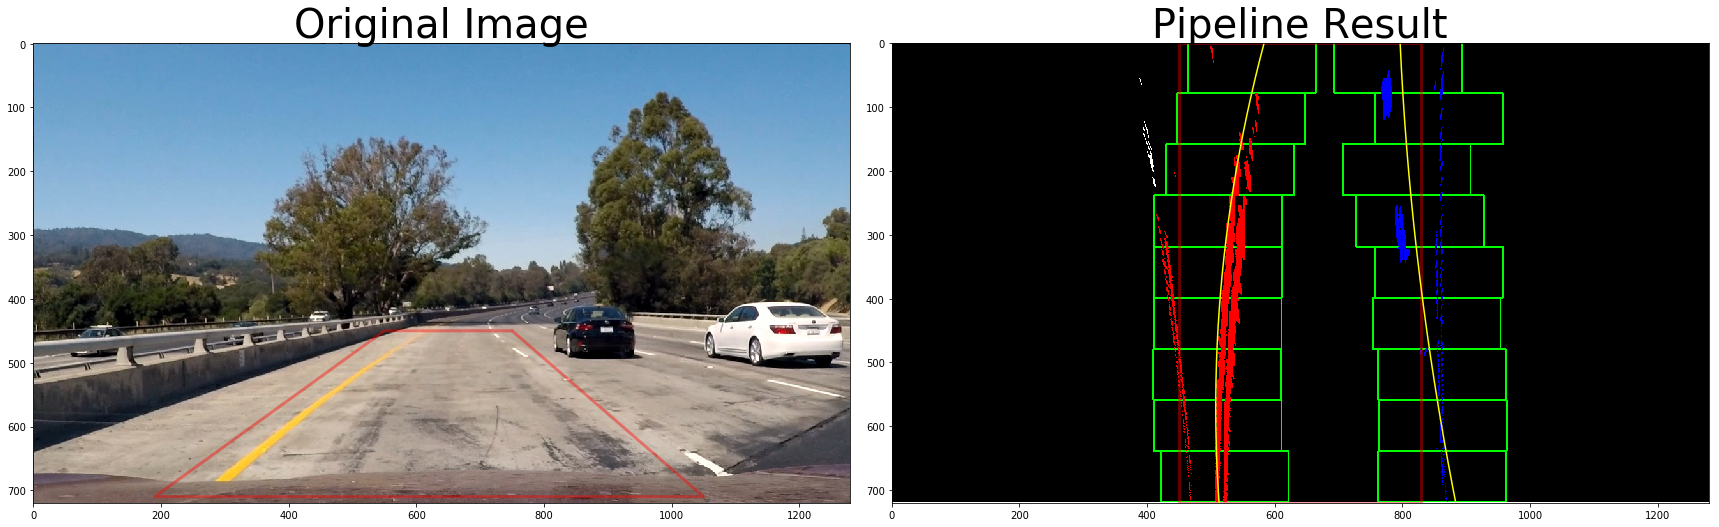

In [12]:
image = mpimg.imread('./test_images/test1.jpg')

height,width = image.shape[:2]

src = np.float32([(750,450),(550,450),
                  (1050,710),
                  (190,710), 
                      ])
dst = np.float32([(width-450,0),
                      (450,0),
                      (width-450,height),
                      (450,height)])

result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius = pipeline(image)
#result, mtx,dist = cal_undistort(result, objpoints, imgpoints)
#height,width = result.shape[:2]

# define source and destination points for transform
#src = np.float32([(750,450),(550,450),
#                  
#                  (1050,710),
#                  (80,710), 
#                  ])
#dst = np.float32([(width-450,0),
#                  (450,0),
#                  (width-450,height),
#                  (450,height)])
#
#result, M, Minv=warp_transform(result,src,dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)

x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [13]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region
def process_image(image):
    result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius = pipeline2(image)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    print('img', image)
    print('newwarp',newwarp)
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Lane Radius of Curvature: {} m".format(int(left_curveradius))
    text2 = "Right Lane Radius of Curvature: {} m".format(int(right_curveradius))
    
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    cv2.putText(result,text2,(400,50), font, 1,(255,255,255),2)
    
    # Find the position of the car
    position_offset=image.shape[1]/2-(pts_left[:,719,0]+pts_right[:,0,0])/2
    #print(position_offset)
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    position_offset_m=position_offset*xm_per_pix
    position=position_offset_m
    #print(position)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(float(-position))
    else:
        text = "Vehicle is {:.2f} m right of center".format(float(position))
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result

image = mpimg.imread('./test_images/test1.jpg')
result= process_image(image)
#print(len(left_fitx))
#print(len(ploty))

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Transformed Image', fontsize=40)



ax2.imshow(result)
plt.show()


NameError: name 'pipeline2' is not defined

In [85]:
#print(right_fitx,left_fitx)
image = mpimg.imread('./test_images/test1.jpg')
warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
print(pts.shape )
c=pts.reshape(1440,2)
print(c.shape)
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
print(pts_left[:,719,0],pts_right[:,0,0],(pts_left[:,719,0]+pts_right[:,0,0])/2,image.shape[1]/2,image.shape[1]/2-(pts_left[:,719,0]+pts_right[:,0,0])/2)

(1, 1440, 2)
(1440, 2)
[ 512.83784233] [ 883.57198442] [ 698.20491337] 640.0 [-58.20491337]


In [ ]:
import glob
# Load test images.
#testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
#                      glob.glob('./test_images/*.jpg')))

testImages = list(map(lambda imageFileName: (imageFileName, mpimg.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))
print(len(testImages))
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
        
#showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 2, 3, (15, 13))
showImages(list(map(lambda img: (img[0], pipeline(img[1])),testImages)), 2, 4, (15, 13))

plt.show()

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1
        
print("line class is defined")

line class is defined


In [16]:
### Import everything needed to edit/save/watch video clips
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip,clips_array
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = './project_out.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(1,16)

#clip1 = VideoFileClip("./project_video.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
final_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#clip2_out = clip1.fl_image(process_image_debug)
#clip2 = clip1.resize(0.70) # downsize 60%
#final_clip = clips_array([[clip1_out, clip2_out]])
#CompositeVideoClip([clip1,clip2,clip3])
                          
%time final_clip.write_videofile(white_output, audio=False)

NameError: name 'pipeline2' is not defined

In [92]:
### Import everything needed to edit/save/watch video clips
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video = VideoFileClip("./project_video.mp4").subclip(1,3)

In [93]:
time video.write_videofile('test_short.mp4', audio=False)

[MoviePy] >>>> Building video test_short.mp4
[MoviePy] Writing video test_short.mp4


 98%|█████████▊| 50/51 [00:01<00:00, 44.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_short.mp4 

CPU times: user 134 ms, sys: 131 ms, total: 265 ms
Wall time: 2.81 s


In [12]:
#The pipeline, converted to a convenient function that can be passed for video processing
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return line_img

def detect_lane_lines(image):
    #This function implements the entire pipeline.
    #0. First, filter out and keep only yellow & white images.
    #1. Convert image to grayscale
    #2. Apply Canny edge detection to detect edge outlines
    #3. Select the region of interest to limit to roughly the extent of lane lines
    #4a. Extract the hough lines, process the lines so that the Left Lane Line pieces are combined as 1 single solid line
    #4b. Similarly process the Right Lane Lin pieces. This processing is done in the modified draw_lines function
    #5. Overlay the processed Hough Lines onto the origina image
    
    #First convert image to HLS space, extract yellow & white lines
    img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white  mask
    lower_range = np.uint8([  0, 200,   0])
    upper_range = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower_range, upper_range)
    # yellow  mask
    lower_range = np.uint8([ 0,   0, 100])
    upper_range = np.uint8([ 50, 255, 255])
    yellow_mask = cv2.inRange(img, lower_range, upper_range)
    # combine  masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    final_mask = cv2.bitwise_and(image, image, mask = mask)
    
    gray=grayscale(final_mask)
    low_threshold=50
    high_threshold=150

    #Gaussian blur
    kernel_size=13
    gauss_blur= gaussian_blur(gray, kernel_size)

    canny_img=canny(gray, low_threshold, high_threshold)
    
    #Triangle defines the location of the lane lines
    left_bottom = [0, 539]
    right_bottom = [900, 539]
    apex = [500, 300]

    #roi=region_of_interest(img=canny_img,vertices=np.array([ [left_bottom,right_bottom,apex] ], np.int32))
    # Pipeline step #3: Find lines using Hough transform
    hough_img=hough_lines(img=canny_img,max_line_gap=100,min_line_len=40,rho=2,theta=np.pi/180,threshold=45)
    #line_img=draw_lines(hough_img, lines, color=[255, 0, 0], thickness=2)
    
    # Pipeline step #4: Overlay the detected hough lines with the original image
    #final_image = weighted_img(hough_img, image)
    final_image=hough_img
    return final_image

In [96]:
def process_image_debug(image):
    result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius = pipeline(image)

    
    return result

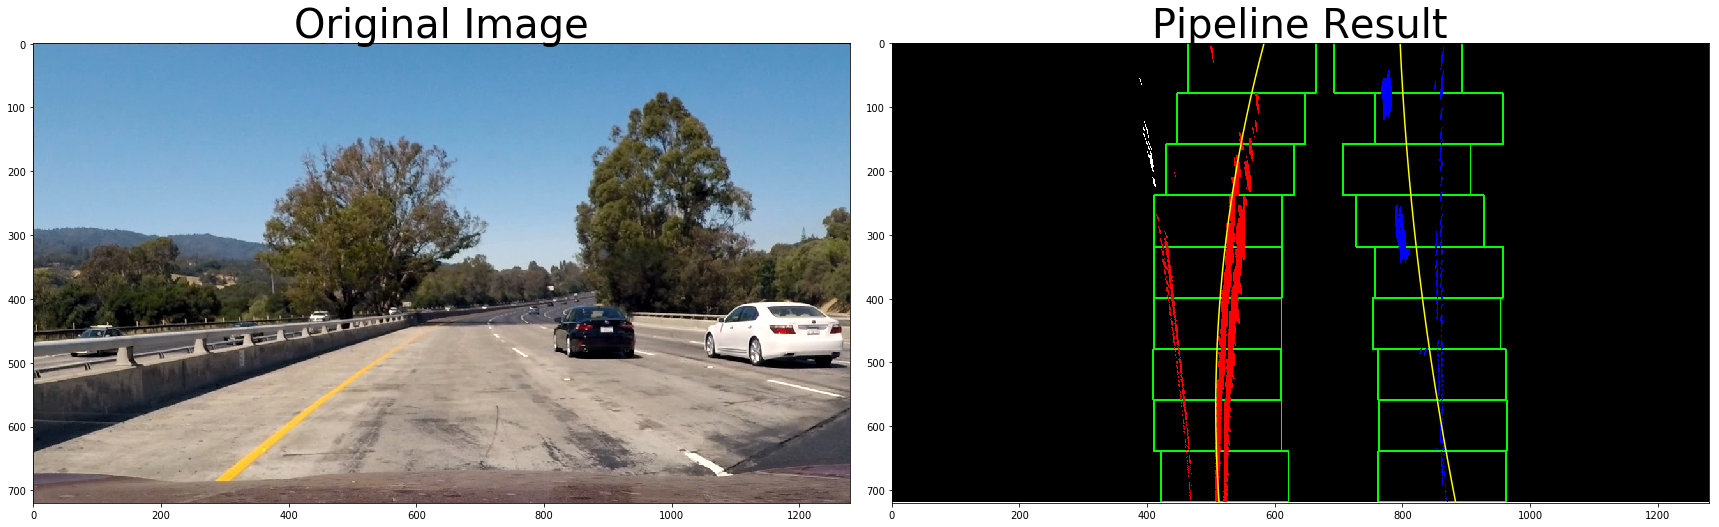

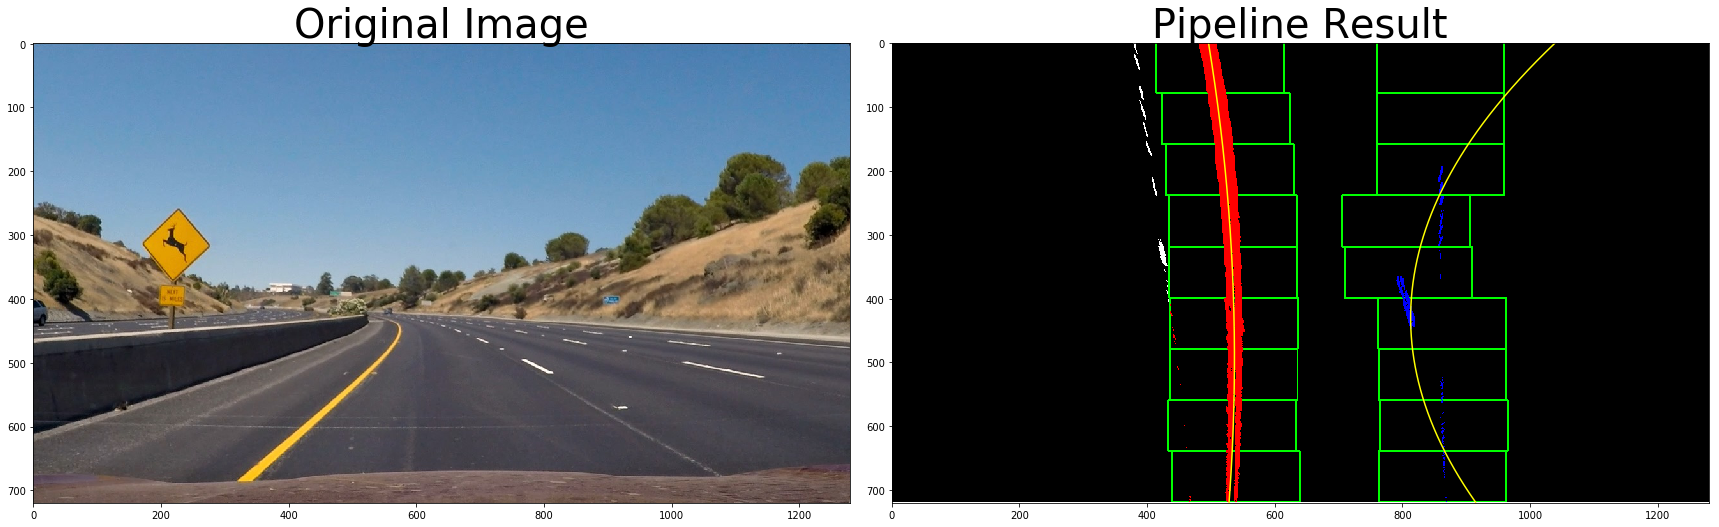

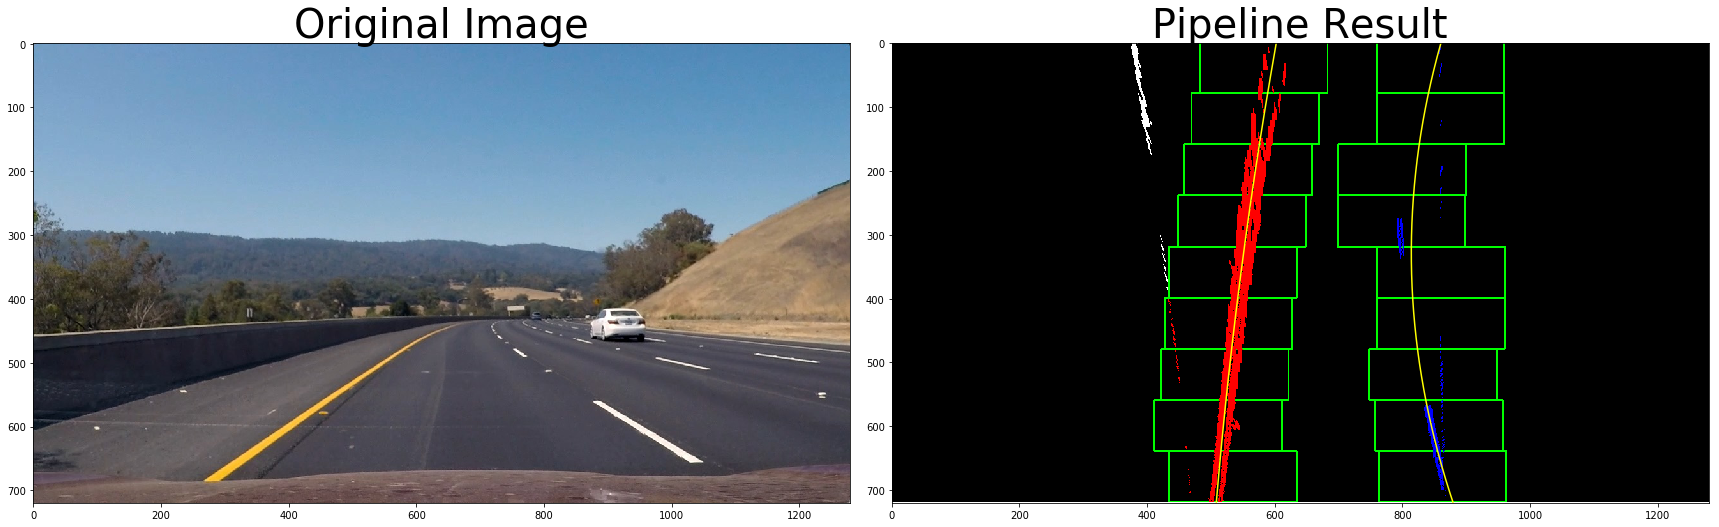

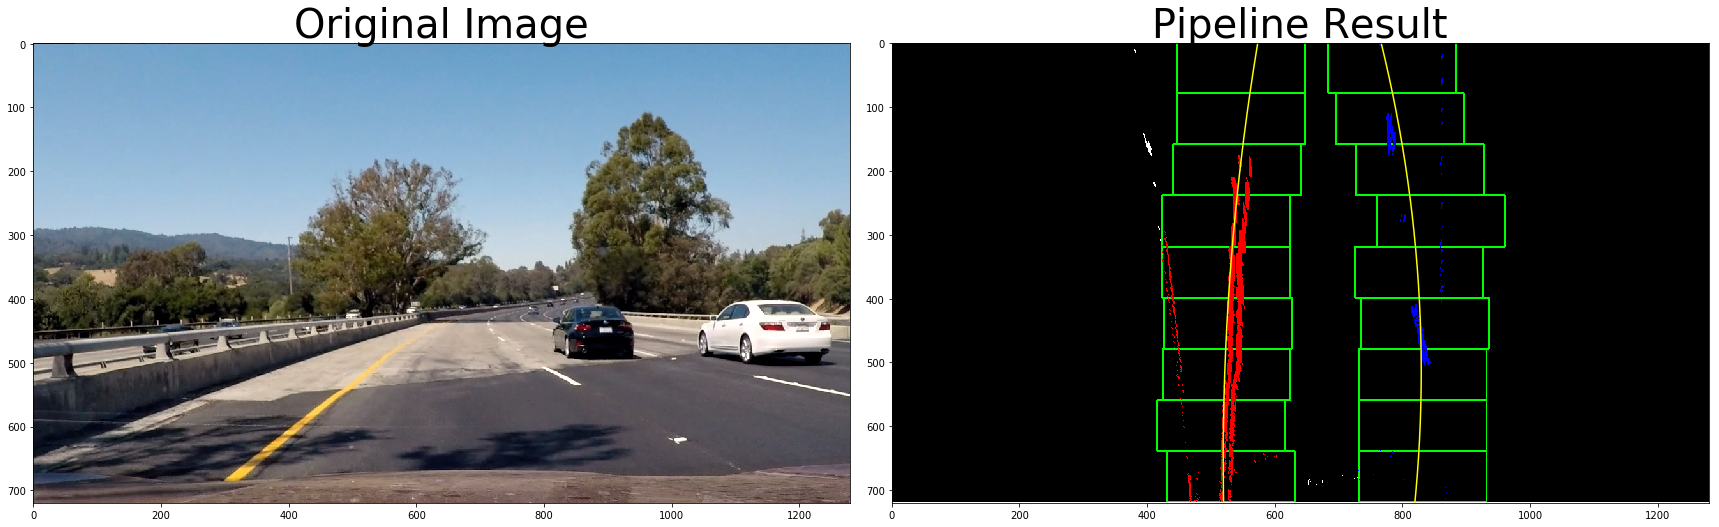

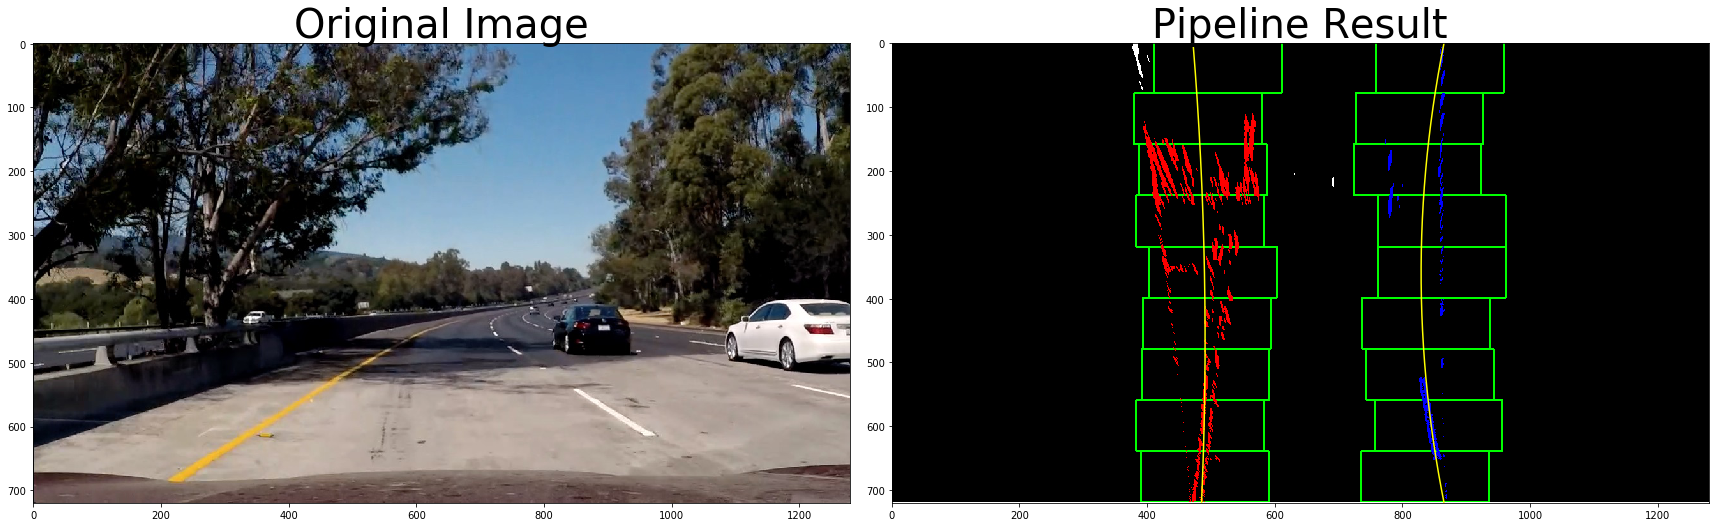

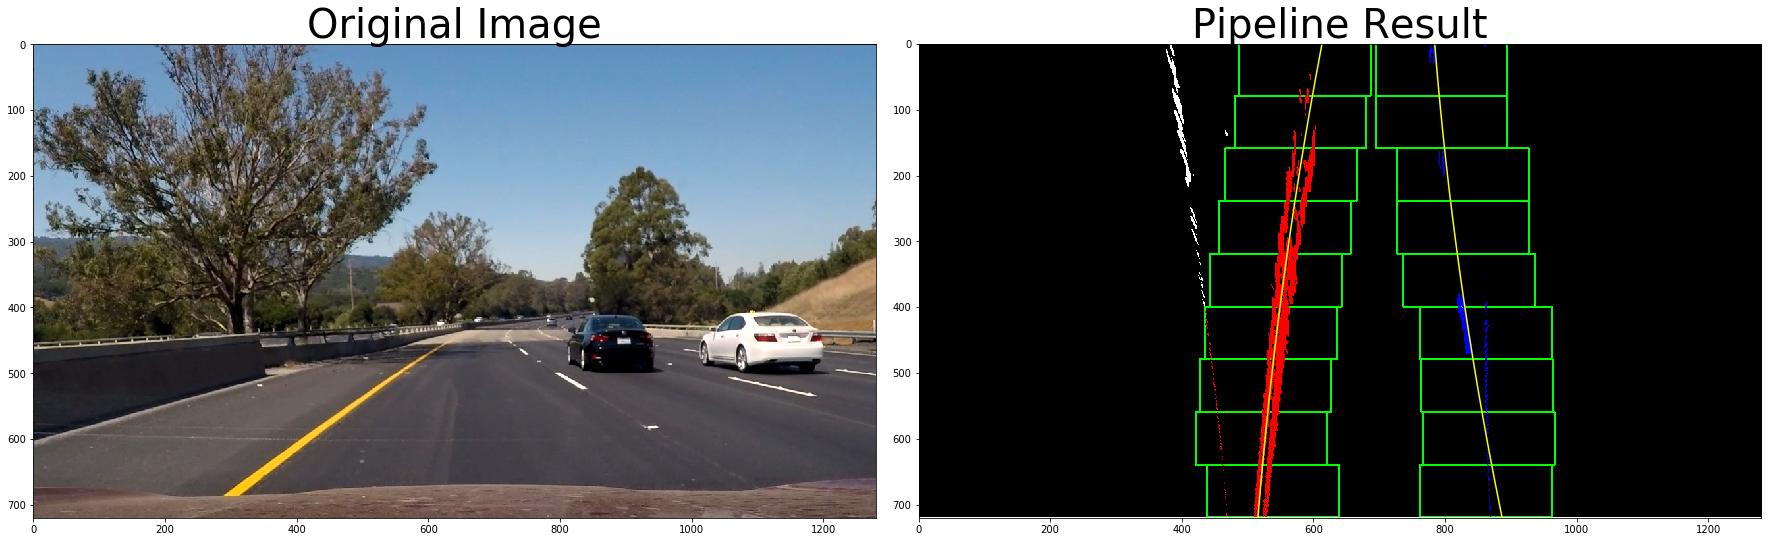

In [30]:
import matplotlib.image as mpimg

for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    #image = cv2.imread(fname)
    image = mpimg.imread(fname)
    result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result,cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
   
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y
left_lane = Line()
right_lane = Line()
# Edit this function to create your own pipeline.
def pipeline2(img): 
    
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    result, mtx,dist = cal_undistort(color_binary, objpoints, imgpoints)

    height,width = result.shape[:2]

    # define source and destination points for transform
    src = np.float32([(750,450),(550,450),

                      (1050,710),
                      (80,710), 
                      ])
    dst = np.float32([(width-450,0),
                      (450,0),
                      (width-450,height),
                      (450,height)])

    top_down, M, Minv=warp_transform(result,src,dst)
    result,left_fitx,right_fitx,ploty,left_curveradius,right_curveradius=window_polyfit(top_down)
    
    return result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius
    
for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    #image = cv2.imread(fname)
    result,left_fitx,right_fitx,ploty,M,Minv,left_curveradius,right_curveradius = pipeline2(image)
    # Warp the image to make lanes parallel to each other
    #top_down, perspective_M, perspective_Minv = corners_unwarp(result, nx, ny, mtx, dist)
    
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result,cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

NameError: name 'Line' is not defined

In [10]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

print("Functions for edge dections are created")
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("function for masking region of interest")

import math
# Function to find the fitting lines from the warped image
def fit_lanes(image):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left = None
    right = None
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    # Find curvatures
    left_curverad  = find_curvature(yvals, left_fitx)
    right_curverad = find_curvature(yvals, right_fitx)
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad

print("fit_lanes are done")

def find_nearest(array,value):
    # Function to find the nearest point from array
    if len(array) > 0:
        idx = (np.abs(array-value)).argmin()
        return array[idx]

def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2        

def sanity_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

# Sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    # If the direction is ok then pass
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .2:
        return right
    # If not then compute the value from the previous values
    else:
        return right_pre + (right_pre - right_pre2)
    
# find_lanes function will detect left and right lanes from the warped image.
# 'n' windows will be used to identify peaks of histograms    
def find_lanes(n, image, x_window, lanes, \
               left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set index1. This is used for placeholder.
    index1 = np.zeros((n+1,2))
    index1[0] = [300, 1100]
    index1[1] = [300, 1100]
    # Set the first left and right values
    left, right = (300, 1100)
    # Set the center
    center = 700
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    for i in range(n-1):
        # set the window range.
        y_window_top = 720-720/n*(i+1)
        y_window_bottom = 720-720/n*i
        # If left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # Find the historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            # Set the direction
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            # Set the center
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > 600:
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
            # Append coordinates to the right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

print("Accessory functions are created")


# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

print("corner_unwarp function is created")

Functions for edge dections are created
function for masking region of interest
fit_lanes are done
Accessory functions are created
corner_unwarp function is created
